# CardioGoodFitness

Статистический анализ данных. Цель выявить типичного пользователя беговой дорожки, а также выяснить отличаются ли пользователи, предпочитающие разные типы беговых дорожек.

## Описание данных 

- Product - тип продукта 
- Age - возраст в годах
- Gender - пол
- Education - образование в годах 
- MaritalStatus - семейный статус 
- Usage - планируют использовать (часы в неделю)
- Fitness - самооценка физической формы по шкале от 1 до 5, где 1 - плохая форма, а 5 - отличная форма. 
- Income - годовой доход
- Miles - планируют пробегать в неделю 

## Подключение библиотек 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plot
import math

## Статистический анализ 

In [2]:
data = pd.read_csv('/datasets/Kaggle/CardioGoodFitness.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Product        180 non-null    object
 1   Age            180 non-null    int64 
 2   Gender         180 non-null    object
 3   Education      180 non-null    int64 
 4   MaritalStatus  180 non-null    object
 5   Usage          180 non-null    int64 
 6   Fitness        180 non-null    int64 
 7   Income         180 non-null    int64 
 8   Miles          180 non-null    int64 
dtypes: int64(6), object(3)
memory usage: 12.8+ KB


In [4]:
data.head()

,Product,Age,Gender,Education,MaritalStatus,Usage,Fitness,Income,Miles
0,TM195,18,Male,14,Single,3,4,29562,112
1,TM195,19,Male,15,Single,2,3,31836,75
2,TM195,19,Female,14,Partnered,4,3,30699,66
3,TM195,19,Male,12,Single,3,3,32973,85
4,TM195,20,Male,13,Partnered,4,2,35247,47


### Вывод

Данные не содержат пустых значений 

### Поле Age

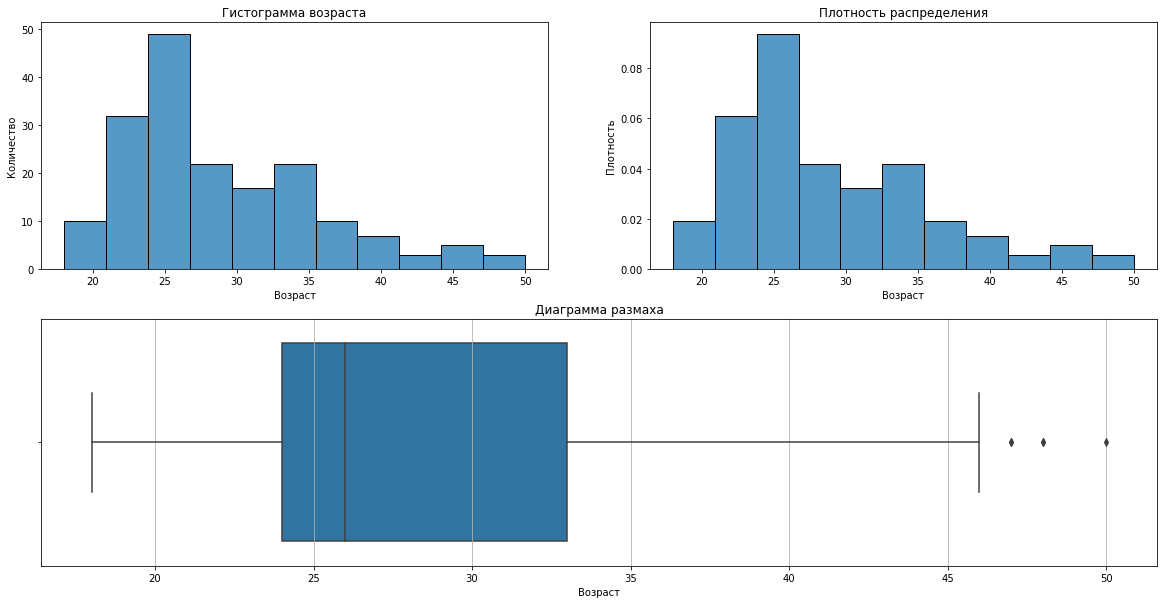

In [5]:
fig = plot.figure(figsize=(20, 10))
ax1 = plot.subplot2grid((2, 2), (0, 0))
sns.histplot(data, x="Age", ax=ax1).set(
    title='Гистограмма возраста',
    xlabel='Возраст', 
    ylabel='Количество'
)

ax1 = plot.subplot2grid((2, 2), (0, 1))
sns.histplot(data, x="Age",  stat="density", ax=ax1).set(
    title='Плотность распределения',
    xlabel='Возраст', 
    ylabel='Плотность'
)

ax1 = plot.subplot2grid((2, 2), (1, 0), colspan=2)

ax1.xaxis.grid(True)
sns.boxplot(x=data['Age'], ax=ax1).set(
    title='Диаграмма размаха',  
    xlabel='Возраст', 
    ylabel=''
)
plot.show()

Распределение содержит небольшое количества выбросов после 45 лет (не многие люди бегают после этого возраста) и предположительно имеет лог-нормальное. Проверим наше предположение.

#### Тестирование поля Age на лог-нормальное распределения 

#### Подготовка данных 

In [6]:
data['Age'].unique()

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 43, 44, 46, 47, 50, 45, 48, 42])

In [7]:
without_outliers = data[data['Age'] < 47]

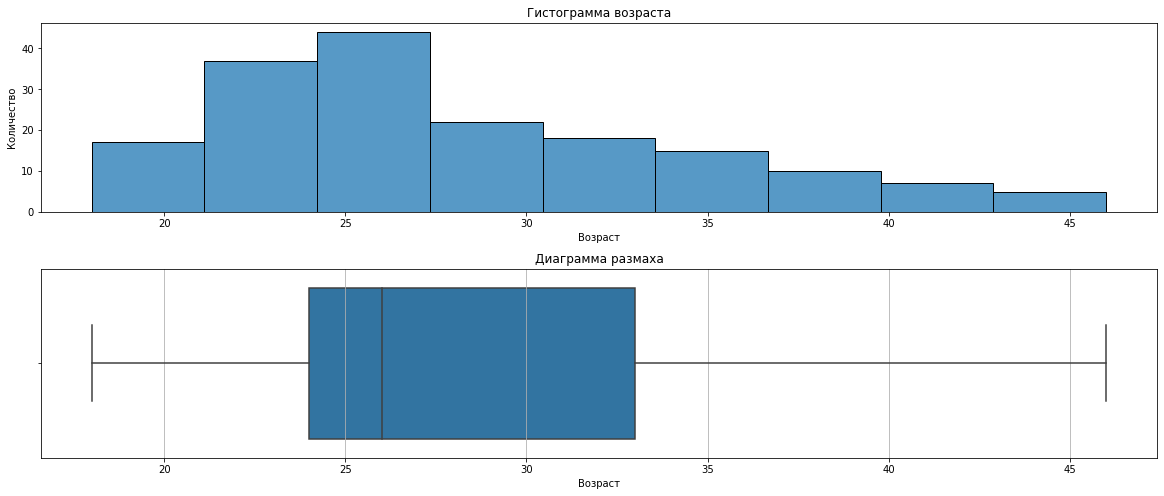

In [8]:
fig = plot.figure(figsize=(20, 8), constrained_layout=False)
plot.subplots_adjust(hspace=0.3)

ax1 = plot.subplot2grid((2, 1), (0, 0))
sns.histplot(without_outliers, x="Age", ax=ax1).set(
    title='Гистограмма возраста',
    xlabel='Возраст', 
    ylabel='Количество'
)

ax1 = plot.subplot2grid((2, 1), (1, 0))
ax1.xaxis.grid(True)
sns.boxplot(x=without_outliers['Age'], ax=ax1).set(
    title='Диаграмма размаха',  
    xlabel='Возраст', 
    ylabel=''
)
plot.show()

In [9]:
without_outliers['Age'].unique()

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 43, 44, 46, 45, 42])

Данные целочисленные (частотные), поэтому для проверки гипотезы подойдет хи-квадрат. 

In [10]:
def do_test(p_value, alpha = 0.05):
    if p_value < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Принимаем нулевую гипотезу")

##### Тест хи-квадрат

###### До удаление выбросов 

In [11]:
def do_frequency(values):
    observer_frequency = np.bincount(values)
    tmp = pd.DataFrame(np.log(values))
    
    params = stats.lognorm.fit(values)
    expected_frequency = [len(data) * stats.lognorm.pdf(x, *params) for x in range(values.max() + 1) ]
    expected_frequency = np.array(expected_frequency)
    
    indexes = np.where(expected_frequency == 0)[0]
    observer_frequency = np.delete(observer_frequency, indexes)
    expected_frequency = np.delete(expected_frequency, indexes)
    
    return observer_frequency, expected_frequency

In [12]:
observer_frequency, expected_frequency = do_frequency(data['Age'])

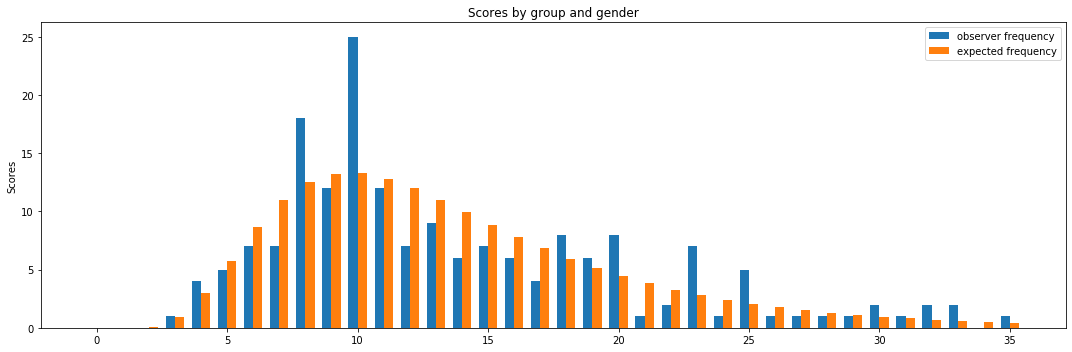

In [13]:
x = np.arange(len(expected_frequency))  
width = 0.35 

fig, ax = plot.subplots(figsize=(15,5))
rects1 = ax.bar(x - width/2, observer_frequency, width, label='observer frequency')
rects2 = ax.bar(x + width/2, expected_frequency, width, label='expected frequency')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.legend()

fig.tight_layout()

plot.show()

H0 - Данные хорошо согласуются с лог-нормальным законом распределения 

H1 - Данные плохо согласуются с лог-нормальным законом распределения 

alpha = 0.05

In [14]:
result = stats.chisquare(observer_frequency, f_exp=expected_frequency)
result

Power_divergenceResult(statistic=47.79898840803665, pvalue=0.0731463520166491)

In [15]:
do_test(result.pvalue)

Принимаем нулевую гипотезу


###### После удаление выбросов 

In [16]:
observer_frequency, expected_frequency = do_frequency(without_outliers['Age'])

H0 - Данные хорошо согласуются с лог-нормальным законом распределения 

H1 - Данные плохо согласуются с лог-нормальным законом распределения 

alpha = 0.05

In [17]:
result = stats.chisquare(observer_frequency, f_exp=expected_frequency)
result

Power_divergenceResult(statistic=44.475330766195086, pvalue=0.055464544461385844)

In [18]:
do_test(result.pvalue)

Принимаем нулевую гипотезу


##### Тест Колмагорова — Смирнова 

###### До удаление выбросов 

In [19]:
params = stats.lognorm.fit(data['Age'])

H0 - Данные хорошо согласуются с лог-нормальным законом распределения 

H1 - Данные плохо согласуются с лог-нормальным законом распределения 

alpha = 0.05

In [20]:
result = stats.kstest(data['Age'], stats.lognorm(*params).cdf)

In [21]:
do_test(result.pvalue)

Принимаем нулевую гипотезу


###### После удаление выбросов 

In [22]:
params = stats.lognorm.fit(without_outliers['Age'])

H0 - Данные хорошо согласуются с лог-нормальным законом распределения 

H1 - Данные плохо согласуются с лог-нормальным законом распределения 

alpha = 0.05

In [23]:
result = stats.kstest(data['Age'], stats.lognorm(*params).cdf)

In [24]:
do_test(result.pvalue)

Принимаем нулевую гипотезу
